In [1]:
# https://developers.arcgis.com/labs/rest/export-a-map/
from PIL import Image
import requests
from pyproj import CRS, Transformer
import json
from pprint import pprint
from io import BytesIO

In [2]:
# 1 settings

west = -140
south = 40
east = -122
north = 51

buffer = 0.2    # How much space to give around bbox in ratio of bbox

width = 200
height = 400

in_wkid = 4326
out_wkid = 3857
bbox_opacity = 0.35
bbox_fill = [255, 165, 0, 160]
bbox_stroke = [255, 127, 0, 255]
bbox_stroke_width = 3
esri_topo_url = "https://services.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer"
api_url = 'https://utility.arcgisonline.com/arcgis/rest/services/Utilities/PrintingTools/GPServer/Export Web Map Task/execute'

In [3]:
# Do easy calcs in WGS84

# 2 get buffered BBOX for displaying map
width_buffer = (east - west) * buffer
height_buffer = (north - south) * buffer

outer_bbox = {
    'west': west - width_buffer,
    'east': east + width_buffer,
    'north': north + height_buffer,
    'south': south - 2*height_buffer, # ensure room for attribution
}

# Can the service handle crossing the Antimeridian? Avoid it for now.
if outer_bbox['west'] < -180:
    outer_bbox['west'] = -180
if outer_bbox['east'] > 180:
    outer_bbox['east'] = 180
if outer_bbox['south'] < -90:
    outer_bbox['south'] = -90
if outer_bbox['north'] > 90:
    outer_bbox['north'] = 90

In [4]:
#6 Craft your json
request_data = {
    'f': 'json',
    'Format': 'PNG32',
    'Layout_Template': 'MAP_ONLY'
}

Web_Map_as_JSON = {}

map_options = {}
map_options['extent'] = {
    "xmin": outer_bbox['west'],
    "ymin": outer_bbox['south'],
    "xmax": outer_bbox['east'],
    "ymax": outer_bbox['north'],
    "spatialReference": {
        "wkid": in_wkid
    }
}
map_options['spatialReference'] = {
    "wkid": out_wkid
}
Web_Map_as_JSON['mapOptions'] = map_options

operational_layers = []

op_layer = {
    "opacity": bbox_opacity
}

feature_collection = {
    "layers": []
}

layer_def = {
      "name": "BBOXpolygon",
      "geometryType": "esriGeometryEnvelope",
      "drawingInfo": {
        "renderer": {
          "type": "simple",
          "symbol": {
            "type": "esriSFS",
            "style": "esriSFSSolid",
            "color": bbox_fill,
            "outline": {
              "type": "esriSLS",
              "style": "esriSLSSolid",
              "color": bbox_stroke,
              "width": bbox_stroke_width
            }
          }
        }
      }
}

feature_set = {
  "features": [
    {
      "geometry": {
        "xmin": west,
        "ymin": south,
        "xmax": east,
        "ymax": north,
        "spatialReference": {
          "wkid": in_wkid
        }
      }
    }
  ]
}

feature_collection['layers'].append({
    "layerDefinition": layer_def,
    "featureSet": feature_set
})

op_layer['featureCollection'] = feature_collection
operational_layers.append(op_layer)

Web_Map_as_JSON['operationalLayers'] = operational_layers

base_map = {
    "title" : "Topographic Basemap",
    "baseMapLayers" :  [
      {
        "url" : esri_topo_url
      }
    ]
}

Web_Map_as_JSON['baseMap'] = base_map

export_options = {
    "outputSize" :  [width,height]
}

Web_Map_as_JSON['exportOptions'] = export_options

request_data['Web_Map_as_JSON'] = json.dumps(Web_Map_as_JSON)

pprint(request_data)

{'Format': 'PNG32',
 'Layout_Template': 'MAP_ONLY',
 'Web_Map_as_JSON': '{"mapOptions": {"extent": {"xmin": -143.6, "ymin": 35.6, '
                    '"xmax": -118.4, "ymax": 53.2, "spatialReference": '
                    '{"wkid": 4326}}, "spatialReference": {"wkid": 3857}}, '
                    '"operationalLayers": [{"opacity": 0.35, '
                    '"featureCollection": {"layers": [{"layerDefinition": '
                    '{"name": "BBOXpolygon", "geometryType": '
                    '"esriGeometryEnvelope", "drawingInfo": {"renderer": '
                    '{"type": "simple", "symbol": {"type": "esriSFS", "style": '
                    '"esriSFSSolid", "color": [255, 165, 0, 160], "outline": '
                    '{"type": "esriSLS", "style": "esriSLSSolid", "color": '
                    '[255, 127, 0, 255], "width": 3}}}}}, "featureSet": '
                    '{"features": [{"geometry": {"xmin": -140, "ymin": 40, '
                    '"xmax": -122, "ymax": 51, "spati

In [5]:
response = requests.post(api_url, data=request_data)
img_url = response.json()['results'][0]['value']['url']
print(img_url)

https://utility.arcgisonline.com/arcgis/rest/directories/arcgisoutput/Utilities/PrintingTools_GPServer/x_____xRerMyY4tjKSQJLrtC9cM0w..x_____x_ags_59484eae-ff50-11ea-91ee-22000bd7a82e.png


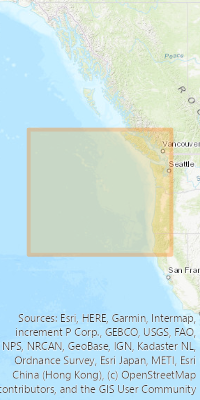

In [6]:
img_response = requests.get(img_url)
image = Image.open(BytesIO(img_response.content))
display(image)

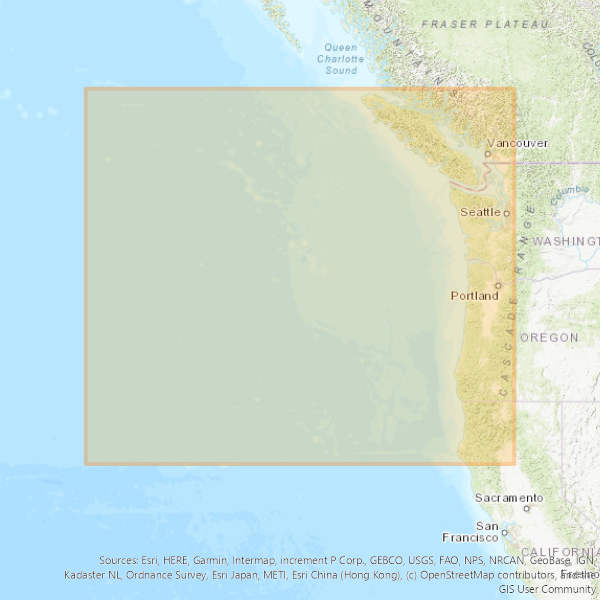

In [7]:
# Closer Look
Web_Map_as_JSON['exportOptions'] = {
    "outputSize" :  [600,600]
}
request_data['Web_Map_as_JSON'] = json.dumps(Web_Map_as_JSON)
response = requests.post(api_url, data=request_data)
img_url = response.json()['results'][0]['value']['url']
img_response = requests.get(img_url)
image = Image.open(BytesIO(img_response.content))
display(image)